In [21]:
using Pkg
Pkg.activate("/storage/mssgwp_grp/msrkhg/ammonia_rpsh/")
using IJulia
using ClusterScripts

# Generating initial conditions
In this notebook, we want to generate initial conditions for excited state dynamics of Ammonia with a variety of methods. 

We will be using [Metropolis-Hastings Monte Carlo](https://nqcd.github.io/NQCDynamics.jl/stable/initialconditions/metropolishastings/#mhmc-sampling) Sampling to generate a set of positions to randomly sample in order to determine thermal averages. As we are modelling Ammonia in the gas phase, velocities will be randomly sampled from a Boltzmann distribution. 

The Metropolis-Hastings algorithm will generate a Markov chain of configurational states from the initial configuration we supply. 

To generate the random configurations, we need to provide the algorithm with a **step size** for each atom type and a **move ratio** determining how many atoms in the molecule to move at once. 

To optimally sample the configuration space of Ammonia, you will need to experiments with the parameters to find the "correct" ones. 

## Starting conditions
According to the equipartition theorem, we would expect a random set of molecular configurations in thermal equilibrium to have an average potential energy of $3N*\frac{k_BT}{2}$. 

To begin with, we will look at generating initial conditions for Surface-hopping methods and classical adiabatic MD. 

**move_ratio:** We will try move ratios from 0.1 to 1.0 in 0.05 intervals

**Starting geometry:** We will use a relaxed geometry of Ammonia based on experimentally determined bond lengths. 

In [22]:
tail=run(`tail -n 36 mc_initial_conditions.jl`)

Process(`tail -n 36 mc_initial_conditions.jl`, ProcessExited(0))

The Julia file [mc_initial_conditions.jl](mc_initial_conditions.jl) contains a definition of all the necessary starting parameters for our simulation. 

The parameters `temperature` and `move_ratio` are set as variables and given as ranges. My [ClusterScripts](https://github.com/NQCD/ClusterScripts) package will take the parameters I have given and build all possible combinations of variable values into a list of 19 temperatures ✖️ 19 move ratio values for each data point. 

We can then submit this list to the HPC cluster of our choice, where many simulations will run in parallel, depending on the resources we have requested. 
If anything goes wrong halfway through, we can use checkpointing to avoid having to run everything again. 


**Now let's test how long one of our trajectories will take:**

In [23]:
run(`./run_montecarlo.sh 1 1 19`)

Process(`./run_montecarlo.sh 1 1 19`, ProcessExited(0))

**You will need to wait for this to complete**
*This should take about 10 minutes*

---

After this job has finished, we can take a closer look at the trajectories we just generated to make sure we can use them as accurate starting conditions for excited state dynamics. 
`ClusterScripts` provides the `merge_file_results` function, which now takes each saved MD simulation job and combines it into a single file and Array. 

In [31]:
using ClusterScripts
include("/storage/mssgwp_grp/msrkhg/ammonia_rpsh/script_repo/initial_distribution.jl") # Loads all packages which were needed for data creation

#! Run this once, then load the output file. 
results=merge_file_results("MC_results.jld2", "montecarlo-ded2/*.jld2", "mc_settings.jld2")

# Run this once the output file was generated #! (needs a lot of RAM)
#results=jldopen("MC_results.jld2")["results"];

19-element Vector{Tuple}:
 (Dict{Symbol, Vector}(:OutputPotentialEnergy => [0.009636429012920278, 0.009636429012920278, 0.009419111507895914, 0.009419111507895914, 0.009419111507895914, 0.009419111507895914, 0.009410988959348984, 0.009410988959348984, 0.009169124703284334, 0.009169124703284334  …  0.0007827564602660014, 0.0007827564602660014, 0.0007827564602660014, 0.0007827564602660014, 0.0006849103825083275, 0.0006849103825083275, 0.0006849103825083275, 0.0006849103825083275, 0.0006849103825083275, 0.0006849103825083275], :OutputPosition => [[0.0 1.91569 -0.901583 -0.901583; 0.0 -0.0 -1.62123 1.62123; 0.0 0.0 0.0 0.0], [0.0 1.91569 -0.901583 -0.901583; 0.0 -0.0 -1.62123 1.62123; 0.0 0.0 0.0 0.0], [-0.00014336429434019162 1.8673968041883677 -0.901583 -0.8880603015758278; 0.0 0.04477542475958268 -1.62123 1.65728304502764; 0.0 -0.03928766867381564 -0.016934069615946325 0.17128272978331216], [-0.00014336429434019162 1.8673968041883677 -0.901583 -0.8880603015758278; 0.0 0.0447754247595826

In [25]:
results_matrix=@view results[:]
#results_matrix=reshape(results_matrix, (19,19))
#results_matrix[1,2][2] # Dimensions are (move_ratio, temperature)

19-element view(::Vector{Tuple}, :) with eltype Tuple:
 (Dict{Symbol, Vector}(:OutputPotentialEnergy => [0.009636429012920278, 0.009636429012920278, 0.009419111507895914, 0.009419111507895914, 0.009419111507895914, 0.009419111507895914, 0.009410988959348984, 0.009410988959348984, 0.009169124703284334, 0.009169124703284334  …  0.0007827564602660014, 0.0007827564602660014, 0.0007827564602660014, 0.0007827564602660014, 0.0006849103825083275, 0.0006849103825083275, 0.0006849103825083275, 0.0006849103825083275, 0.0006849103825083275, 0.0006849103825083275], :OutputPosition => [[0.0 1.91569 -0.901583 -0.901583; 0.0 -0.0 -1.62123 1.62123; 0.0 0.0 0.0 0.0], [0.0 1.91569 -0.901583 -0.901583; 0.0 -0.0 -1.62123 1.62123; 0.0 0.0 0.0 0.0], [-0.00014336429434019162 1.8673968041883677 -0.901583 -0.8880603015758278; 0.0 0.04477542475958268 -1.62123 1.65728304502764; 0.0 -0.03928766867381564 -0.016934069615946325 0.17128272978331216], [-0.00014336429434019162 1.8673968041883677 -0.901583 -0.88806030157

*This will also take a while due to the slow IO of /storage*

---

# Validating initial conditions
Now that we have our very long simulation trajectories for a variety of conditions, we can compare potential energies at different temperatures and move ratios. 

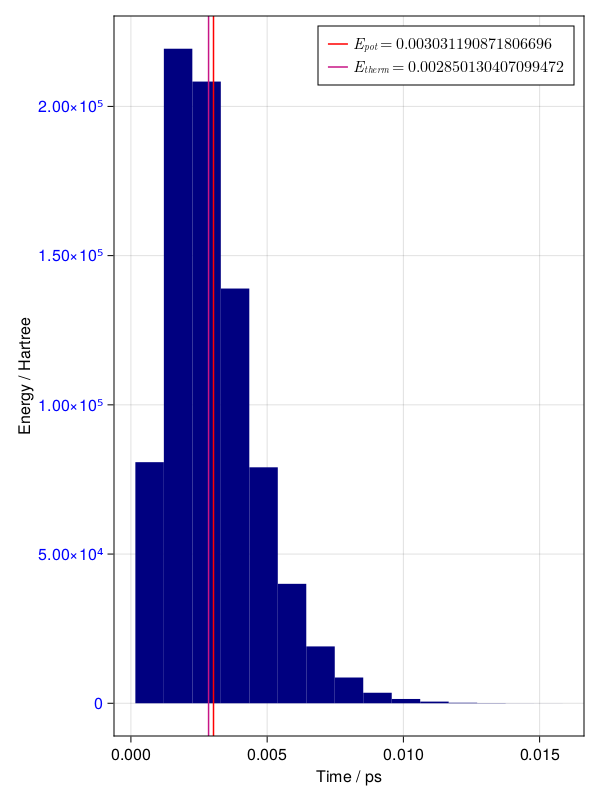

In [26]:
#? Change the trajectory here to look at different initial conditions
conditions=results_matrix[5]


using Statistics
using CairoMakie
using LaTeXStrings
using LinearAlgebra
E_therm=6/2*ustrip(uconvert(u"hartree", conditions[2]["temperature"]*u"k_au"))

energy_figure=Figure(resolution=(600,800))
E_pot_ax=Axis(energy_figure[1,1], xlabel="Time / ps", ylabel="Energy / Hartree", yticklabelcolor=:blue)
hist!(conditions[1][:OutputPotentialEnergy]; color=:navy)
vlines!(mean(conditions[1][:OutputPotentialEnergy]); label=L"E_{pot}=%$(mean(conditions[1][:OutputPotentialEnergy]))", color=:red)
vlines!(E_therm; label=L"E_{therm}=%$(E_therm)", color=:mediumvioletred)
axislegend(E_pot_ax)
energy_figure

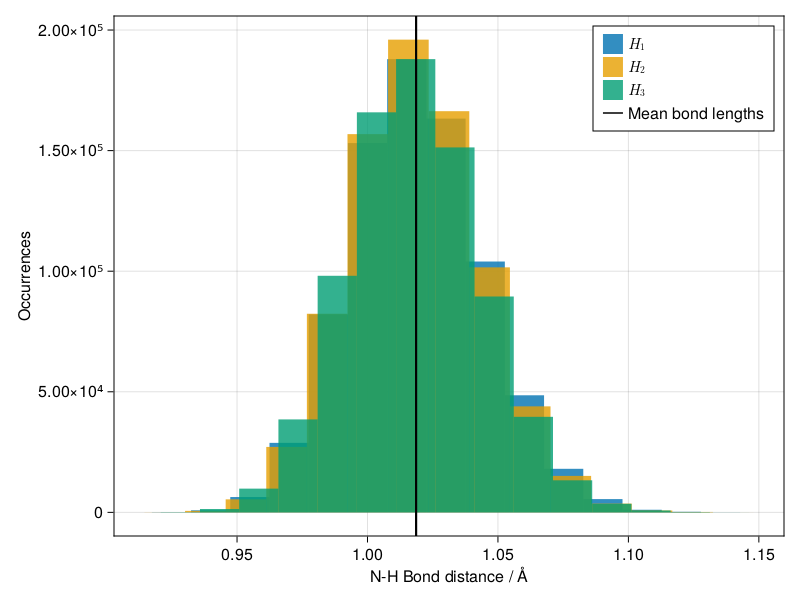

In [27]:
h1_bl=map(x->au_to_ang.(norm(x[:,2]-x[:,1])), conditions[1][:OutputPosition])
h2_bl=map(x->au_to_ang.(norm(x[:,3]-x[:,1])), conditions[1][:OutputPosition])
h3_bl=map(x->au_to_ang.(norm(x[:,4]-x[:,1])), conditions[1][:OutputPosition])

bl_hist=hist(h1_bl; label=L"H_1")
hist!(h2_bl; label=L"H_2")
hist!(h3_bl;label=L"H_3")
vlines!(bl_hist.axis, mean.([h1_bl, h2_bl, h3_bl]); color=:black, label="Mean bond lengths")
axislegend(bl_hist.axis)
bl_hist.axis.xlabel="N-H Bond distance / Å"
bl_hist.axis.ylabel="Occurrences"
bl_hist

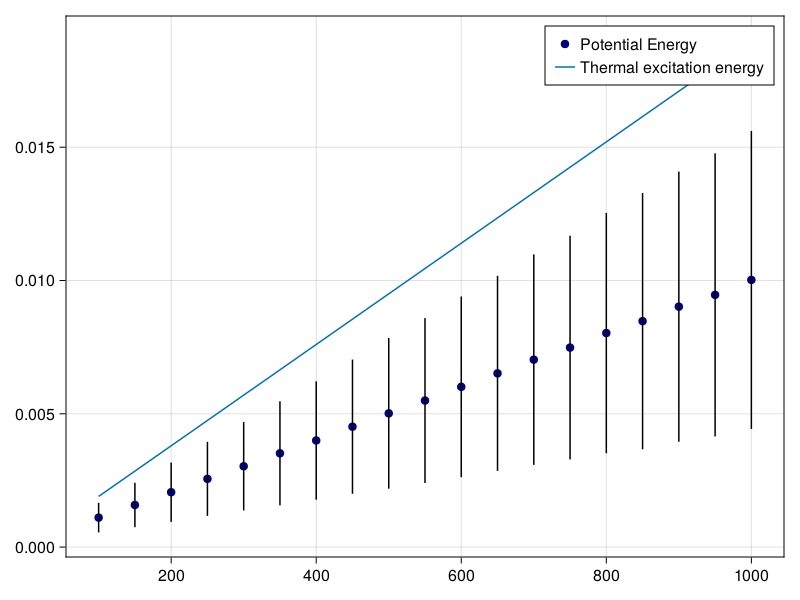

In [28]:
pot_energy_per_dof=zeros(Float64, 0)
pot_error=zeros(Float64, 0)
kin_energy_per_dof=zeros(Float64, 0)
kin_error=zeros(Float64, 0)
temperatures=zeros(Float64, 0)
for temperature in results
    push!(temperatures, ustrip(temperature[2]["temperature"]))
    push!(pot_energy_per_dof, mean(temperature[1][:OutputPotentialEnergy]))
    push!(pot_error, std(temperature[1][:OutputPotentialEnergy]))
end
E_th(T)=12/2*austrip(T*u"K")

energy_plot=scatter(temperatures, pot_energy_per_dof; color=:navy, label="Potential Energy")
errorbars!(temperatures, pot_energy_per_dof, pot_error)
#scatter!(temperatures, kin_energy_per_dof; color=:firebrick, label="Kinetic Energy")
#errorbars!(temperatures, kin_energy_per_dof, kin_error)
lines!(temperatures, E_th.(temperatures), label="Thermal excitation energy")
axislegend()
energy_plot


---
# Initial conditions for excited state dynamics
Now that we have made sure our Monte Carlo sampling has accurately sampled the configuration space, we can create the initial distributions of positions and velocities in the excited state. 

In [32]:
if !isdir("distributions")
    mkdir("distributions")
end
for temperature in results

    distribution_from_single_datapoint(([temperature[1]], temperature[2]), PureState(2, Adiabatic()), "distributions/MC_T$(temperature[2]["temperature"])_PureState2.jld2")
end


# Monte Carlo sampling for Ring polymer simulations
We can use the same method as above to generate initial conditions for excited state ring polymer simulations. 

To do so, we will initialise a ring polymer with a set of random configurations from our previous MC simulations. 

In [ ]:
run(`sbatch run_rpmontecarlo.sh`)